In [1]:
import pandas as pd
import numpy as np
from os import path
from scipy.stats import ttest_ind, ttest_rel
from scipy.stats import kstest
import pyvttbl as pt
from collections import namedtuple
from scipy.stats import wilcoxon
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='whitegrid')

In [2]:
# set file names
basedir = '/home/data/nbc/physics-learning/data/behavioral-data/analyses/physics-learning-behavioral'
datadir = 'datafiles'
plotdir = 'plots'

f_acc = path.join(basedir, datadir, 'fci_accuracy_rt.txt')
f_acc_gender = path.join(basedir, datadir, 'fci_accuracy_rt_gender_class_matched.txt')
f_class = path.join(basedir, datadir, 'c123456-demographics.txt')

cols = ['Subject', 'Session', 'Mean FCI Accuracy', 'Mean Non-FCI Accuracy', 'Mean FCI RT',  'Mean Non-FCI RT']

# read in files
df_acc1 = pd.read_csv(f_acc, sep='\t')
df_acc_wgender = pd.read_csv(f_acc_gender, sep='\t')
df_class = pd.read_csv(f_class, sep='\t')

# update column name for merging
df_class['Group'] = df_class['Group'].map({'Trad': 'Lecture', 'Mod': 'Modeling'})
df_class = df_class.rename(columns={'PID': 'Subject', 'Group': 'Class'})

# merge df's
df_acc2 = df_acc1.merge(df_acc_wgender[['Subject', 'Session', 'Gender']], on=['Subject', 'Session'])
df_acc = df_acc2.merge(df_class[['Subject', 'Class']],  on=['Subject'])

# update session name for clarity
df_acc['Session'] = df_acc['Session'].map({'session-0': 'pre', 'session-1': 'post'})
df_acc = df_acc.rename(columns={'Mean Non-FCI Accuracy': 'Mean Control Accuracy', 
                                'Mean Non-FCI RT': 'Mean Control RT'})
# drop unmatched data from df
unmatched = []
for subid in df_acc['Subject'].unique():    
    row = df_acc.loc[df_acc['Subject'] == subid, 'Mean FCI Accuracy'].index
    if len(row) == 1:
        unmatched.append(row)
for i in unmatched:
    df_acc.drop(i, inplace = True)

df_acc.to_csv('test_csv.csv', sep='\t')
df_acc.head()

,Subject,Session,Mean FCI Accuracy,Mean Control Accuracy,Mean FCI RT,Mean Control RT,Mean FCI Screen1 RT,Mean FCI Screen2 RT,Mean FCI Screen3 RT,Mean Non-FCI Screen1 RT,Mean Non-FCI Screen2 RT,Mean Non-FCI Screen3 RT,Gender,Class
0,101,pre,0.333333,0.888889,20889.666667,18146.111111,7194.111111,6198.000000,7497.555556,7245.444444,2817.666667,8083.000000,F,Lecture
1,101,post,0.444444,1.000000,15754.111111,15741.888889,5844.777778,4764.888889,5144.444444,6333.777778,3370.111111,6038.000000,F,Lecture
2,102,pre,0.222222,0.888889,18121.111111,15907.111111,7461.777778,4093.555556,6565.777778,6357.888889,2415.777778,7133.444444,M,Modeling
3,102,post,0.555556,1.000000,17289.000000,16284.555556,4861.111111,4589.555556,7838.333333,5885.888889,2055.666667,8343.000000,M,Modeling
4,103,pre,0.444444,1.000000,20477.666667,14463.555556,5530.777778,5820.000000,9126.888889,5617.777778,1953.222222,6892.555556,M,Lecture


In [3]:
def plot_prepost_hists(measures, conditions, df, group_string):
    # dfs should be of type df_group1, df_group2...
    sns.set(palette="bright", color_codes=True)
    
    gender = ['Men', 'Women']
    class_type = ['Modeling', 'Lecture']
    
    for meas in measures:
        for cond in conditions:
            fig, ax = plt.subplots(figsize=(8, 6))
            for sess in df['Session'].unique():
                sess_df = df.loc[df['Session']==sess]
                sns.distplot(sess_df['Mean {0} {1}'.format(cond, meas)], 
                             ax=ax, kde=False, bins=10, label=sess)

            legend = ax.legend(frameon=True)
            if group_string=='all':
                plt.title('Pre- to Post-Instruction {0}: {1} Condition'.format(meas, cond))
            elif group_string=='gender':
                plt.title('Pre- to Post-Instruction {0} in {1}: {2} Condition'.format(meas,gender[i],cond))
            elif group_string=='class':
                plt.title('Pre- to Post-Instruction {0} in {1} Students: {2} Condition'.format(meas,class_type[i],cond))
            else:
                print 'argument 4 can only take strings equivalent to "all", "gender", or "class"'
            frame = legend.get_frame()
            frame.set_facecolor('white')
            frame.set_edgecolor('black')
            ax.set_ylabel('Frequency')
            if group_string=='all':
                fig.savefig(path.join(basedir, plotdir, 
                                      'mean_fci_{0}cond_{1}_pre2post.png'.format(cond.lower(), meas.lower())
                                     ), dpi=400)
            elif group_string=='gender':
                fig.savefig(path.join(basedir, plotdir, 
                                      'mean_fci_{0}cond_{1}_pre2post_{2}only.png'.format(cond.lower(),meas.lower(),gender[i].lower())
                                     ), dpi=400)
            elif group_string=='class':
                fig.savefig(path.join(basedir, plotdir, 
                                  'mean_fci_{0}cond_{1}_pre2post_{2}only.png'.format(cond.lower(),meas.lower(),class_type[i].lower())
                                 ), dpi=400)
            else:
                print 'argument 4 can only take strings equivalent to "all", "gender", or "class"'

In [4]:
def plot_diff_bysess_hists(measures, conditions, df, group_string):
    # dfs should be of type df_pre or df_post
    sns.set(palette="muted", color_codes=True)
    
    gender = ['Men', 'Women']
    class_type = ['Modeling', 'Lecture']
    sess = ['pre', 'post']
    
    for meas in measures:
        for cond in conditions:
            fig, ax = plt.subplots(figsize=(8, 6))
            if group_string == 'gender':
                for gen in df['Gender'].unique():
                    gen_df = df.loc[df['Gender']==gen]
                    sns.distplot(gen_df['Mean {0} {1}'.format(cond, meas)], 
                                 ax=ax, kde=False, bins=10, label=gen)
            elif group_string == 'class':
                for cls in df['Class'].unique():
                    cls_df = df.loc[df['Class']==cls]
                    sns.distplot(cls_df['Mean {0} {1}'.format(cond, meas)], 
                                 ax=ax, kde=False, bins=10, label=cls)
            else:
                'argument 4 can only take strings equivalent to "all", "gender", or "class"'

            legend = ax.legend(frameon=True)
            if group_string == 'gender':
                plt.title('Gender Differences {0}-Instruction {1} in all Students: {2} Condition'.format(sess[i].capitalize(),meas,cond))
            elif group_string == 'class':
                plt.title('Class Differences {0}-Instruction {1} in all Students: {2} Condition'.format(sess[i].capitalize(),meas,cond))
            else:
                print 'argument 4 can only take strings equivalent to "all", "gender", or "class"'
            frame = legend.get_frame()
            frame.set_facecolor('white')
            frame.set_edgecolor('black')
            ax.set_ylabel('Frequency')
            if group_string == 'gender':
                fig.savefig(path.join(basedir, plotdir, 
                                      'mean_fci_{0}cond_{1}_gender{2}.png'.format(cond,sess[i],meas)), dpi=400)
            elif group_string == 'class':
                fig.savefig(path.join(basedir, plotdir, 
                                                  'mean_fci_{0}cond_{1}_class{2}.png'.format(cond,sess[i],meas)), dpi=400)
            else:
                print 'argument 4 can only take strings equivalent to "all", "gender", or "class"'

In [5]:
# Time: Shapiro-Wilk Normality Test

# Separate data frames
df_pre = df_acc[df_acc['Session']=='pre']
df_post = df_acc[df_acc['Session']=='post']

cond = 'FCI'
meas = 'Accuracy'
data1 = df_pre['Mean {0} {1}'.format(cond,meas)]
data2 = df_post['Mean {0} {1}'.format(cond,meas)]
datalist = [data1, data2]

# normality test
for i, data in enumerate(datalist):
    stat, p = shapiro(data)
    if i == 0:
        print('FCI Accuracy Pre')
    elif i == 1:
        print('FCI Accuracy Post')
    else:
        print('something went wrong')
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

FCI Accuracy Pre
Statistics=0.963, p=0.004
Sample does not look Gaussian (reject H0)
FCI Accuracy Post
Statistics=0.955, p=0.001
Sample does not look Gaussian (reject H0)


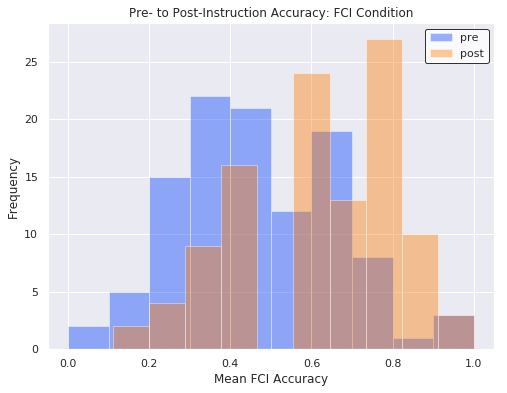

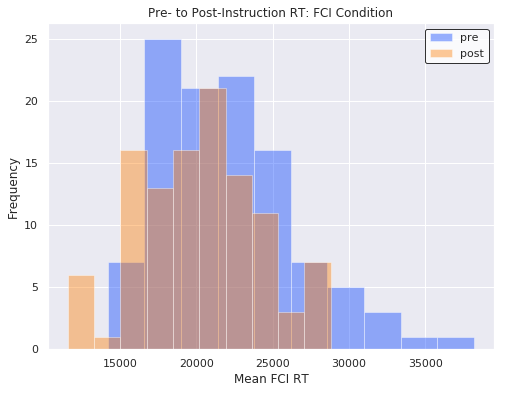

In [6]:
# Pre to post instruction plots: all sutdents
# Separate data frames
df_m = df_acc[df_acc['Gender']=='M']
df_f = df_acc[df_acc['Gender']=='F']

conditions = ['FCI']#, 'Control']
measures = ['Accuracy', 'RT']
dfs = [df_m, df_f]

plot_prepost_hists(measures, conditions, df_acc, 'all')

In [35]:
## Accuracy and RT tests post to pre: all students
# Get means for pre and post
mean_df = df_acc.groupby('Session').mean()
sem_df = df_acc.groupby('Session').sem()

# Separate data frames
df_pre = df_acc[df_acc['Session']=='pre']
df_post = df_acc[df_acc['Session']=='post']

conditions = ['FCI', 'Control']
measures = ['Accuracy', 'RT']

# t tests (for normal data)
print('Paired T-Test')
numtests = 4
for meas in measures:
    for cond in conditions:            
        tstat = ttest_rel(df_pre['Mean {0} {1}'.format(cond,meas)], 
                          df_post['Mean {0} {1}'.format(cond,meas)])
        if tstat.pvalue<0.05/numtests:
            print '______________________________________________________________________________________________'
            print '\nPre- to Post-Instruction Mean {0}: {1} Condition By'.format(
                meas,cond), mean_df['Mean {0} {1}'.format(cond,meas)], '\nPre- to Post-Instruction {0} SEM: {1} Condition By'.format(meas,cond), sem_df['Mean {0} {1}'.format(cond,meas)]
            print 'P val:', tstat.pvalue
            print '*SIGNIFICANT (Bonferroni) difference detected across time for {0} {1} in all students'.format(
                cond,meas)
            print '______________________________________________________________________________________________'

        else:
            print 'No significant differences detected across time for {0} {1} in all students'.format(
                cond,meas)

# wilcoxon signed-ranked test for non-gaussian data
print('______________________________________________________________________________________________')
print('______________________________________________________________________________________________')
print('\nWelcoxon Test')
numtests = 4
for meas in measures:
    for cond in conditions:            
        data1, data2 = df_pre['Mean {0} {1}'.format(cond,meas)], df_post['Mean {0} {1}'.format(cond,meas)]
        stat, p = wilcoxon(data1, data2)
        if p<0.05/numtests:
            print '______________________________________________________________________________________________'
            print '\nPre- to Post-Instruction Mean {0}: {1} Condition By'.format(
                meas,cond), mean_df['Mean {0} {1}'.format(cond,meas)], '\nPre- to Post-Instruction {0} SEM: {1} Condition By'.format(meas,cond), sem_df['Mean {0} {1}'.format(cond,meas)]
            print 'P val:', p
            print '*SIGNIFICANT (Bonferroni) difference detected across time for {0} {1} in all students'.format(
                cond,meas)
            print '______________________________________________________________________________________________'

        else:
            print 'No significant differences detected across time for {0} {1} in all students'.format(
                cond,meas)


Paired T-Test
______________________________________________________________________________________________

Pre- to Post-Instruction Mean Accuracy: FCI Condition By Session
post    0.612140
pre     0.462963
Name: Mean FCI Accuracy, dtype: float64 
Pre- to Post-Instruction Accuracy SEM: FCI Condition By Session
post    0.019364
pre     0.020852
Name: Mean FCI Accuracy, dtype: float64
P val: 7.745096604160792e-13
*SIGNIFICANT (Bonferroni) difference detected across time for FCI Accuracy in all students
______________________________________________________________________________________________
No significant differences detected across time for Control Accuracy in all students
______________________________________________________________________________________________

Pre- to Post-Instruction Mean RT: FCI Condition By Session
post    20203.804527
pre     22061.092593
Name: Mean FCI RT, dtype: float64 
Pre- to Post-Instruction RT SEM: FCI Condition By Session
post    374.263951
pre

In [8]:
# Sex: Shapiro-Wilk Normality Test
cond = 'FCI'
meas = 'Accuracy'
df_m = df_acc[df_acc['Gender']=='M']
df_f = df_acc[df_acc['Gender']=='F']
data1 = df_m['Mean {0} {1}'.format(cond,meas)]
data2 = df_f['Mean {0} {1}'.format(cond,meas)]
datalist = [data1, data2]

# normality test
for i, data in enumerate(datalist):
    stat, p = shapiro(data)
    if i == 0:
        print('FCI Accuracy M')
    elif i == 1:
        print('FCI Accuracy F')
    else:
        print('something went wrong')
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

FCI Accuracy M
Statistics=0.950, p=0.000
Sample does not look Gaussian (reject H0)
FCI Accuracy F
Statistics=0.955, p=0.002
Sample does not look Gaussian (reject H0)


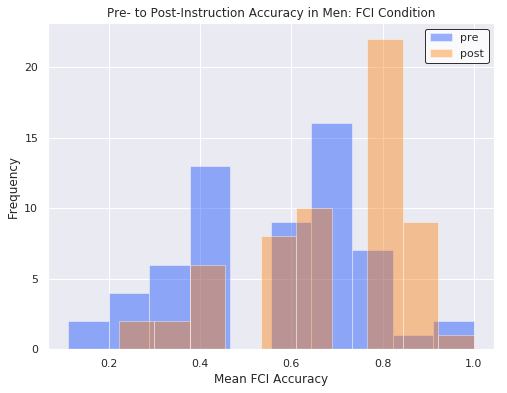

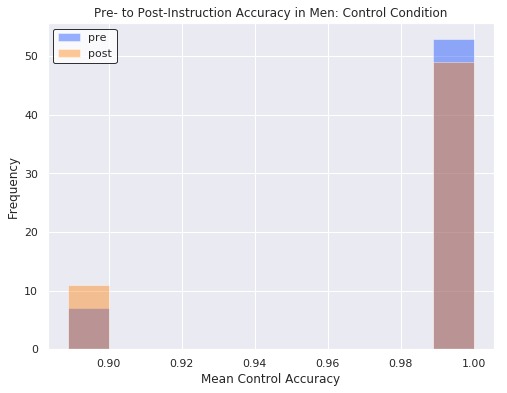

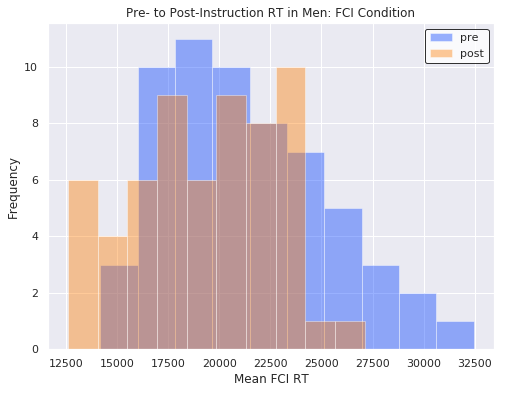

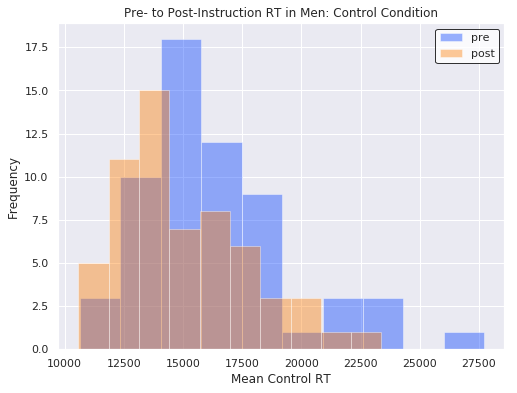

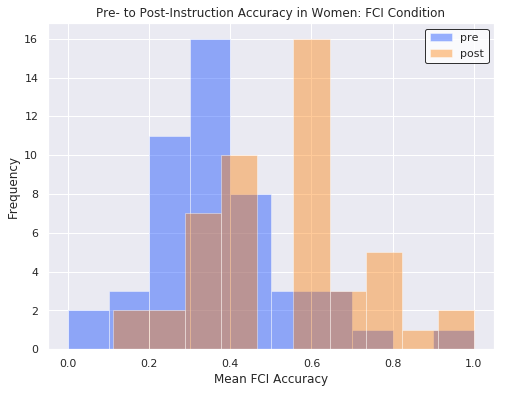

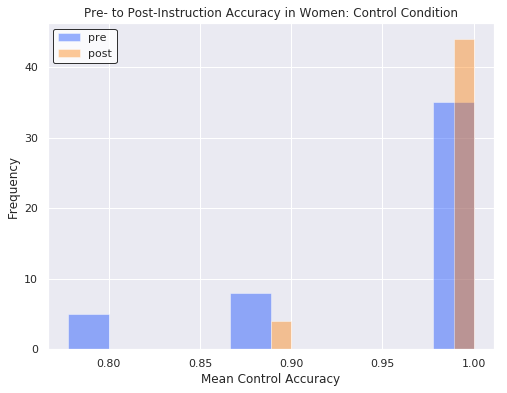

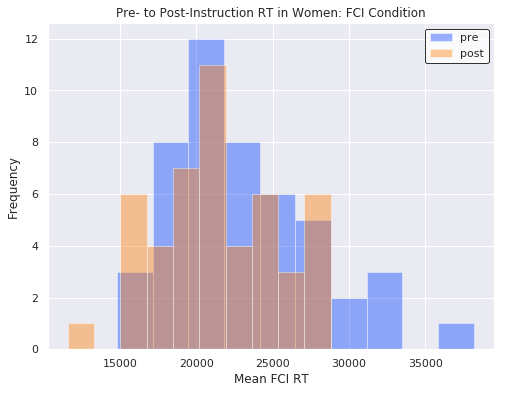

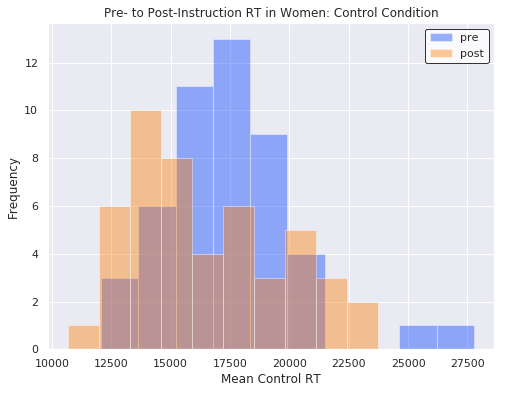

In [9]:
# Pre to post instruction plots: separated by sex
# Separate data frames
df_m = df_acc[df_acc['Gender']=='M']
df_f = df_acc[df_acc['Gender']=='F']

conditions = ['FCI', 'Control']
measures = ['Accuracy', 'RT']
gender = ['Men', 'Women']
dfs = [df_m, df_f]

for i,df in enumerate(dfs):
    plot_prepost_hists(measures, conditions, df, 'gender')

In [10]:
## Accuracy and RT t-tests post to pre: by sex
# Get means for pre and post
df_m_mean = df_m.groupby('Session').mean()
df_f_mean = df_f.groupby('Session').mean()

# Separate data frames
df_m_pre = df_m[df_m['Session']=='pre']
df_m_post = df_m[df_m['Session']=='post']
df_f_pre = df_f[df_f['Session']=='pre']
df_f_post = df_f[df_f['Session']=='post']

conditions = ['FCI', 'Control']
measures = ['Accuracy', 'RT']
gender = ['Male', 'Female']
dfs = [[df_m_pre, df_m_post, df_m_mean], [df_f_pre, df_f_post, df_f_mean]]

# t tests (for normal data)
print('Paired t-test')
numtests=8
for i,df in enumerate(dfs):
    for meas in measures:
        for cond in conditions:
            tstat = ttest_rel(df[0]['Mean {0} {1}'.format(cond,meas)], 
                              df[1]['Mean {0} {1}'.format(cond,meas)])
            if tstat.pvalue<0.05/numtests:
                print '______________________________________________________________________________________________'

                print '\nPre- to Post-Instruction {0} in {1} Students Only: {2} Condition By'.format(
                    meas,gender[i],cond), df[2]['Mean {0} {1}'.format(cond,meas)]
                print 'P val:', tstat.pvalue
                print '*SIGNIFICANT (Bonferroni) difference detected across time for {0} {1} in {2} Students'.format(
                    cond,meas,gender[i])
                print '______________________________________________________________________________________________'

            else:
                print 'No significant differences detected across time for {0} {1} in {2} Students'.format(
                    cond,meas,gender[i])

# wilcoxon signed-ranked test for non-gaussian data
print('______________________________________________________________________________________________')
print('______________________________________________________________________________________________')
print('\nWelcoxon Test')
print('Independent samples t-test')
numtests=8
for i,df in enumerate(dfs):
    for meas in measures:
        for cond in conditions:
            data1, data2 = df[0]['Mean {0} {1}'.format(cond,meas)], df[1]['Mean {0} {1}'.format(cond,meas)]
            stat, p = wilcoxon(data1, data2)
            if p<0.05/numtests:
                print '______________________________________________________________________________________________'

                print '\nPre- to Post-Instruction {0} in {1} Students Only: {2} Condition By'.format(
                    meas,gender[i],cond), df[2]['Mean {0} {1}'.format(cond,meas)]
                print 'P val:', p
                print '*SIGNIFICANT (Bonferroni) difference detected across time for {0} {1} in {2} Students'.format(
                    cond,meas,gender[i])
                print '______________________________________________________________________________________________'

            else:
                print 'No significant differences detected across time for {0} {1} in {2} Students'.format(
                    cond,meas,gender[i])

Paired t-test
______________________________________________________________________________________________

Pre- to Post-Instruction Accuracy in Male Students Only: FCI Condition By Session
post    0.683333
pre     0.548148
Name: Mean FCI Accuracy, dtype: float64
P val: 9.862076284964108e-08
*SIGNIFICANT (Bonferroni) difference detected across time for FCI Accuracy in Male Students
______________________________________________________________________________________________
No significant differences detected across time for Control Accuracy in Male Students
______________________________________________________________________________________________

Pre- to Post-Instruction RT in Male Students Only: FCI Condition By Session
post    19267.348148
pre     21285.568518
Name: Mean FCI RT, dtype: float64
P val: 0.0014229694976626592
*SIGNIFICANT (Bonferroni) difference detected across time for FCI RT in Male Students
_____________________________________________________________________

In [11]:
# Class: Shapiro-Wilk Normality Test
cond = 'FCI'
meas = 'Accuracy'
df_mod = df_acc[df_acc['Class']=='Modeling']
df_lec = df_acc[df_acc['Class']=='Lecture']
data1 = df_mod['Mean {0} {1}'.format(cond,meas)]
data2 = df_lec['Mean {0} {1}'.format(cond,meas)]
datalist = [data1, data2]

# normality test
for i, data in enumerate(datalist):
    stat, p = shapiro(data)
    if i == 0:
        print('FCI Accuracy Mod')
    elif i == 1:
        print('FCI Accuracy Lec')
    else:
        print('something went wrong')
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

FCI Accuracy Mod
Statistics=0.966, p=0.006
Sample does not look Gaussian (reject H0)
FCI Accuracy Lec
Statistics=0.955, p=0.001
Sample does not look Gaussian (reject H0)


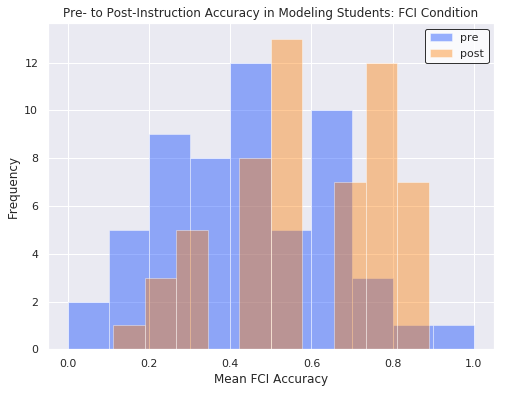

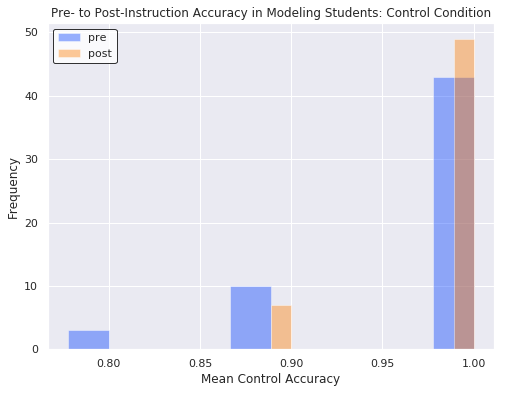

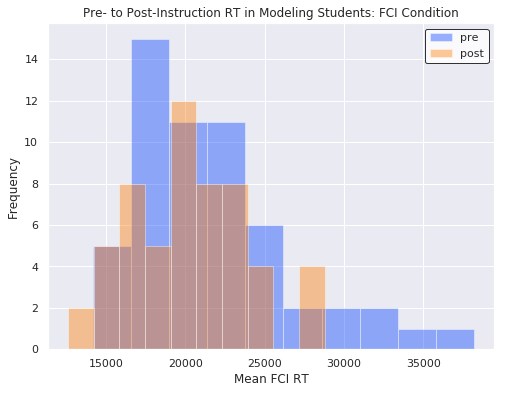

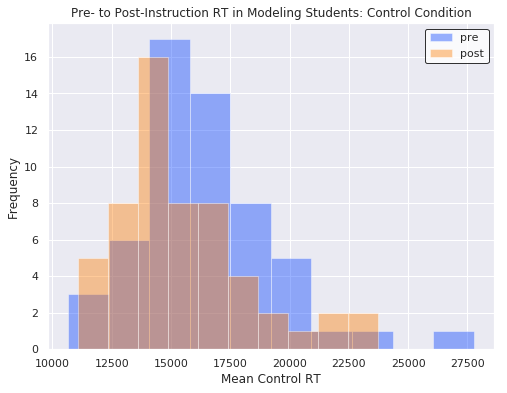

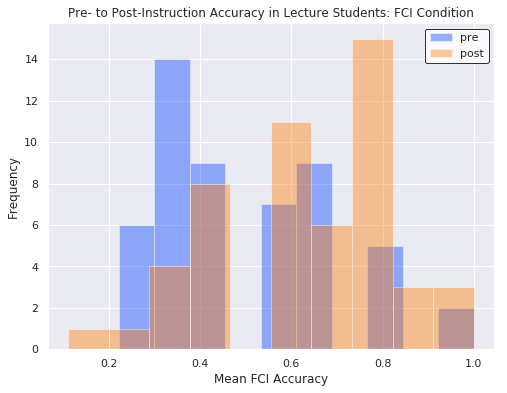

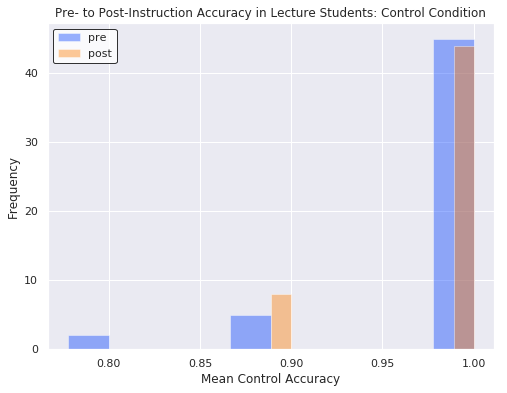

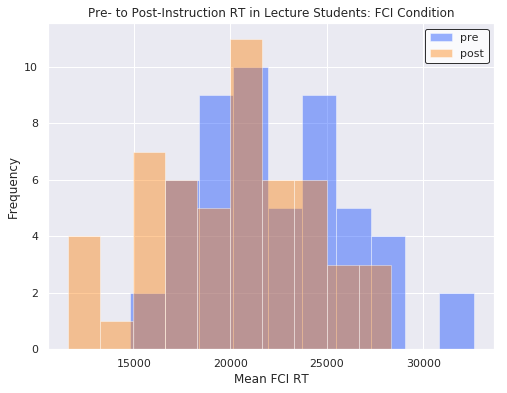

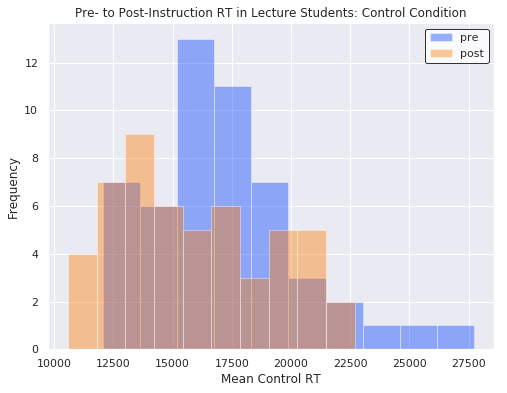

In [12]:
# Pre to post instruction plots: separated by class
# Separate data frames
df_mod = df_acc[df_acc['Class']=='Modeling']
df_lec = df_acc[df_acc['Class']=='Lecture']

conditions = ['FCI', 'Control']
measures = ['Accuracy', 'RT']
dfs = [df_mod, df_lec]

for i,df in enumerate(dfs):
    plot_prepost_hists(measures, conditions, df, 'class')

In [13]:
## Accuracy and RT t-tests post to pre: by class
# Get means for pre and post
df_mod_mean = df_mod.groupby('Session').mean()
df_lec_mean = df_lec.groupby('Session').mean()

# Separate data frames
df_mod_pre = df_mod[df_mod['Session']=='pre']
df_mod_post = df_mod[df_mod['Session']=='post']
df_lec_pre = df_lec[df_lec['Session']=='pre']
df_lec_post = df_lec[df_lec['Session']=='post']

conditions = ['FCI', 'Control']
measures = ['Accuracy', 'RT']
class_type = ['Modeling', 'Lecture']
dfs = [[df_mod_pre, df_mod_post, df_mod_mean], [df_lec_pre, df_lec_post, df_lec_mean]]

# t tests (for notmal data)
print('Paired samples t-test')
numtests=8
for i,df in enumerate(dfs):
    for meas in measures:
        for cond in conditions:
            tstat = ttest_rel(df[0]['Mean {0} {1}'.format(cond,meas)], 
                              df[1]['Mean {0} {1}'.format(cond,meas)])
            if tstat.pvalue<0.05/numtests:
                print '______________________________________________________________________________________________'

                print '\nPre- to Post-Instruction {0} in {1} Students Only: {2} Condition By'.format(
                    meas,class_type[i],cond), df[2]['Mean {0} {1}'.format(cond,meas)]
                print 'P val:', tstat.pvalue                
                print '*SIGNIFICANT (Bonferroni) difference detected across time for {0} {1} in {2} Students'.format(
                    cond,meas,class_type[i])
                print '______________________________________________________________________________________________'
            else:
                print 'No significant differences detected across time for {0} {1} in {2} Students'.format(
                    cond,meas,class_type[i])
                
# wilcoxon signed-ranked test for non-gaussian data
print('______________________________________________________________________________________________')
print('______________________________________________________________________________________________')
print('\nWelcoxon Test')
print('Independent samples t-test')
# Wilcoxon sign-ranked tests for non-normal data
numtests=8
for i,df in enumerate(dfs):
    for meas in measures:
        for cond in conditions:
            data1, data2 = df[0]['Mean {0} {1}'.format(cond,meas)], df[1]['Mean {0} {1}'.format(cond,meas)]
            stat, p = wilcoxon(data1, data2)
            if p<0.05/numtests:
                print '______________________________________________________________________________________________'

                print '\nPre- to Post-Instruction {0} in {1} Students Only: {2} Condition By'.format(
                    meas,class_type[i],cond), df[2]['Mean {0} {1}'.format(cond,meas)]
                print 'P val:', p                
                print '*SIGNIFICANT (Bonferroni) difference detected across time for {0} {1} in {2} Students'.format(
                    cond,meas,class_type[i])
                print '______________________________________________________________________________________________'
            else:
                print 'No significant differences detected across time for {0} {1} in {2} Students'.format(
                    cond,meas,class_type[i])

Paired samples t-test
______________________________________________________________________________________________

Pre- to Post-Instruction Accuracy in Modeling Students Only: FCI Condition By Session
post    0.597222
pre     0.432540
Name: Mean FCI Accuracy, dtype: float64
P val: 5.075658291330698e-08
*SIGNIFICANT (Bonferroni) difference detected across time for FCI Accuracy in Modeling Students
______________________________________________________________________________________________
No significant differences detected across time for Control Accuracy in Modeling Students
No significant differences detected across time for FCI RT in Modeling Students
No significant differences detected across time for Control RT in Modeling Students
______________________________________________________________________________________________

Pre- to Post-Instruction Accuracy in Lecture Students Only: FCI Condition By Session
post    0.628205
pre     0.495726
Name: Mean FCI Accuracy, dtype: f

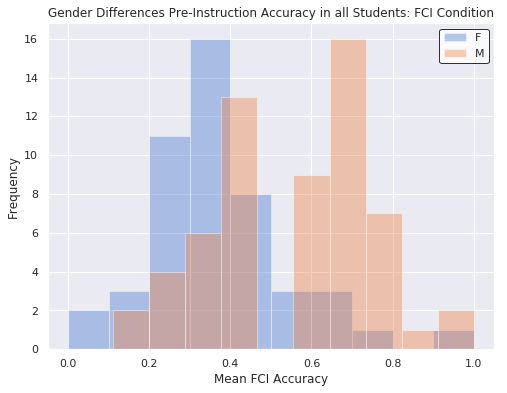

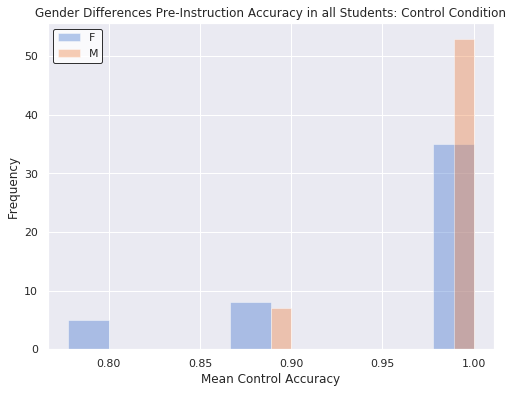

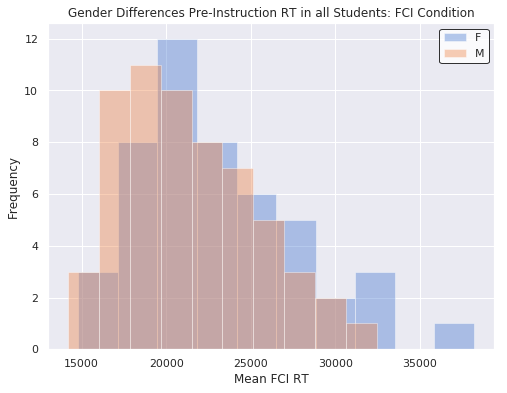

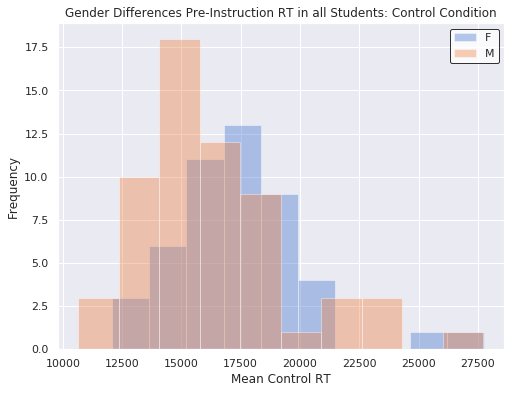

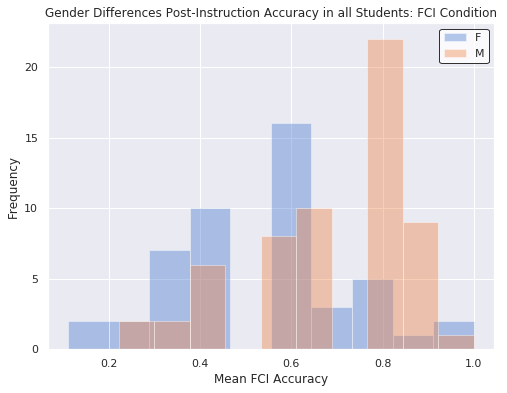

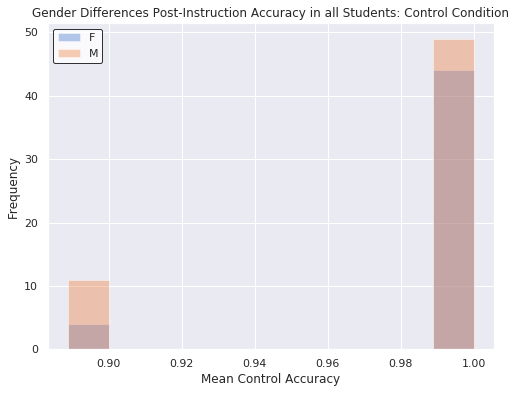

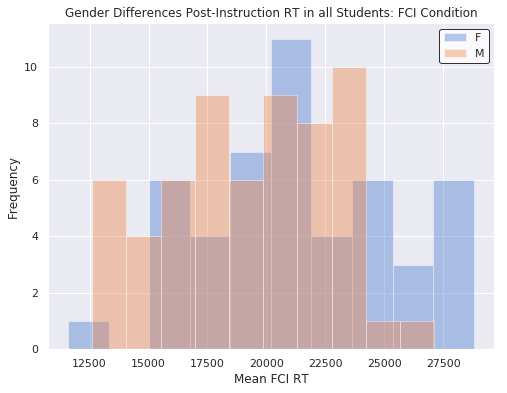

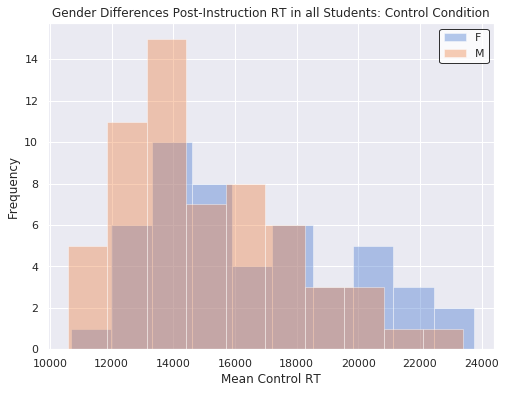

In [14]:
# gender difference plots, each session separately
# Separate data frames
df_acc_pre = df_acc[df_acc['Session']=='pre']
df_acc_post = df_acc[df_acc['Session']=='post']

conditions = ['FCI', 'Control']
measures = ['Accuracy', 'RT']
dfs = [df_acc_pre, df_acc_post]

for i,df in enumerate(dfs):  
    plot_diff_bysess_hists(measures, conditions, df, 'gender')

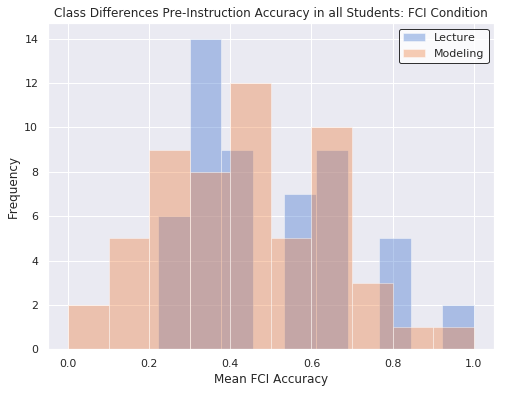

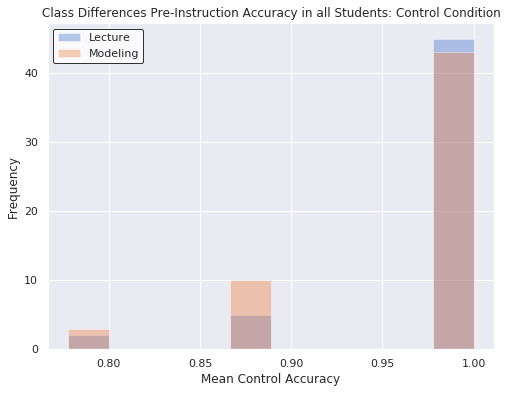

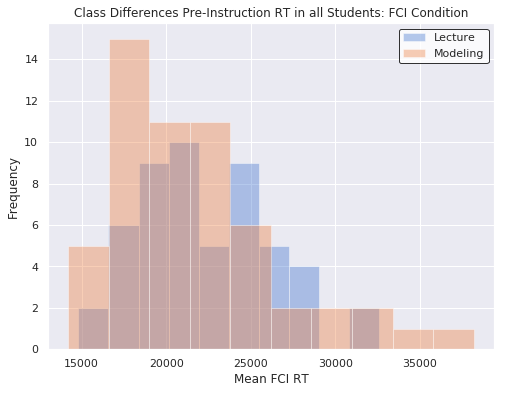

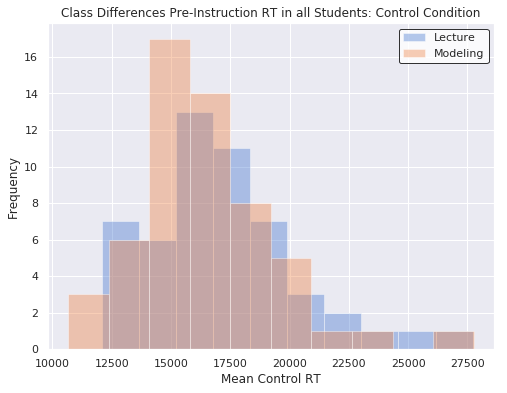

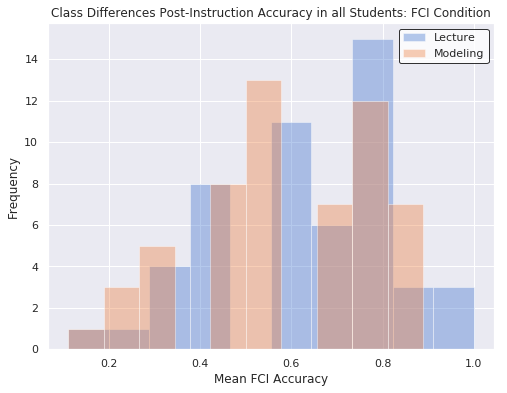

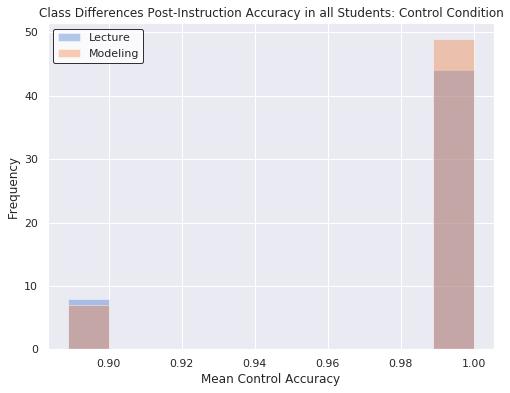

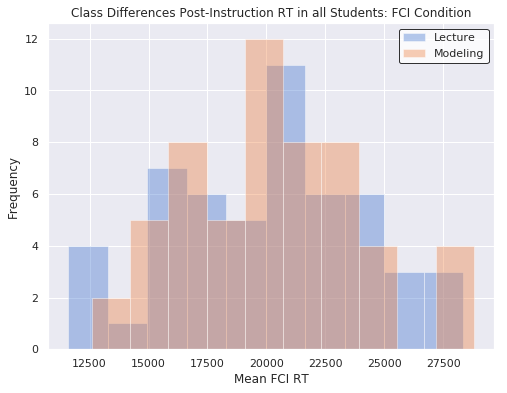

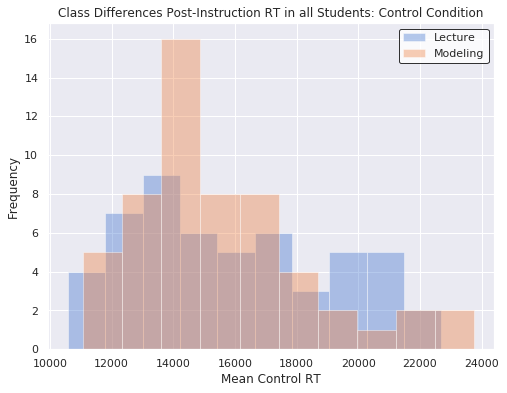

In [15]:
# class difference plots, each session separately
sns.set(palette="muted", color_codes=True)

# Separate data frames
df_acc_pre = df_acc[df_acc['Session']=='pre']
df_acc_post = df_acc[df_acc['Session']=='post']

conditions = ['FCI', 'Control']
measures = ['Accuracy', 'RT']
sess = ['pre', 'post']
dfs = [df_acc_pre, df_acc_post]

for i,df in enumerate(dfs): 
    plot_diff_bysess_hists(measures, conditions, df, 'class')

In [16]:
## Accuracy and RT t-tests class: pre and post sessions separately

# Get means for modeling and lecture
df_pre_mean = df_acc_pre.groupby('Class').mean()
df_post_mean = df_acc_post.groupby('Class').mean()

# Separate data frames
df_mod_pre = df_acc_pre[df_acc_pre['Class']=='Modeling']
df_mod_post = df_acc_post[df_acc_post['Class']=='Modeling']
df_lec_pre = df_acc_pre[df_acc_pre['Class']=='Lecture']
df_lec_post = df_acc_post[df_acc_post['Class']=='Lecture']

conditions = ['FCI', 'Control']
measures = ['Accuracy', 'RT']
sess = ['pre', 'post']
dfs = [[df_mod_pre, df_lec_pre, df_pre_mean], [df_mod_post, df_lec_post, df_post_mean]]

# t tests
numtests=8
for i,df in enumerate(dfs):
    for meas in measures:
        for cond in conditions:
            tstat = ttest_ind(df[0]['Mean {0} {1}'.format(cond,meas)], 
                              df[1]['Mean {0} {1}'.format(cond,meas)])
            if tstat.pvalue<0.05/numtests:
                print '______________________________________________________________________________________________'

                print '\nClass Difference {0}-Instruction {1}: {2} Condition By'.format(
                    sess[i].capitalize(),meas,cond), df[2]['Mean {0} {1}'.format(cond,meas)]
                print 'P val:', tstat.pvalue
                print '*SIGNIFICANT (Bonferroni) {0}-Instruction difference detected across classes for {1} {2}'.format(
                    sess[i],cond,meas)
                print '______________________________________________________________________________________________'

            else:
                print 'No significant {0}-instruction differences detected across classes for {1} {2}'.format(
                    sess[i],cond,meas)


No significant pre-instruction differences detected across classes for FCI Accuracy
No significant pre-instruction differences detected across classes for Control Accuracy
No significant pre-instruction differences detected across classes for FCI RT
No significant pre-instruction differences detected across classes for Control RT
No significant post-instruction differences detected across classes for FCI Accuracy
No significant post-instruction differences detected across classes for Control Accuracy
No significant post-instruction differences detected across classes for FCI RT
No significant post-instruction differences detected across classes for Control RT


In [17]:
# repeated measues ANOVAs are not currently supported in python. Running tests in R.

In [18]:
df_acc_pre_gender = df_acc_pre.melt(id_vars='Gender', value_vars=['Mean FCI Accuracy', 'Mean Control Accuracy'], 
                            var_name='Accuracy_Pre')
df_acc_post_gender = df_acc_post.melt(id_vars='Gender', value_vars=['Mean FCI Accuracy', 'Mean Control Accuracy'], 
                            var_name='Accuracy_Post')
df_rt_pre_gender = df_acc_pre.melt(id_vars='Gender', value_vars=['Mean FCI RT', 'Mean Control RT'], 
                            var_name='RT_Pre')
df_rt_post_gender = df_acc_post.melt(id_vars='Gender', value_vars=['Mean FCI RT', 'Mean Control RT'], 
                            var_name='RT_Post')

df_acc_pre_gender.head()

,Gender,Accuracy_Pre,value
0,F,Mean FCI Accuracy,0.333333
1,M,Mean FCI Accuracy,0.222222
2,M,Mean FCI Accuracy,0.444444
3,F,Mean FCI Accuracy,0.444444
4,M,Mean FCI Accuracy,0.333333


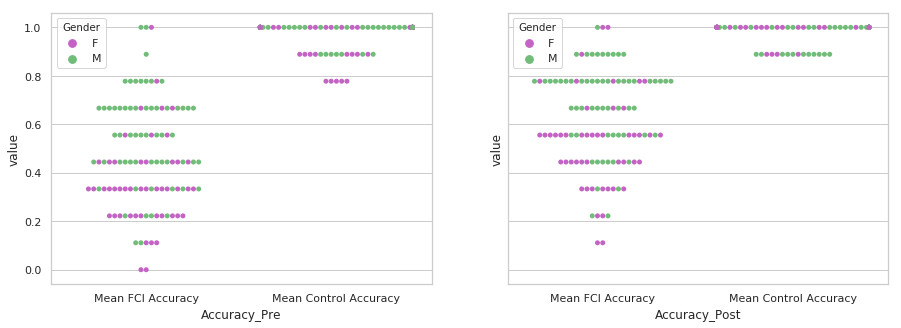

In [19]:
sns.set_style(style='whitegrid')

#print sns.crayons

crayons = sns.crayon_palette(['Fuchsia', 'Fern'])
class_crayons = sns.crayon_palette(['Copper', 'Cornflower'])
dark_crayons = sns.crayon_palette(['Royal Purple', 'Tropical Rain Forest'])
class_dark_crayons = sns.crayon_palette(['Raw Sienna', 'Indigo'])

fig, ax = plt.subplots(1, ncols=2, figsize=(15, 5), sharey=True)
g = sns.swarmplot(x="Accuracy_Pre", y="value", hue="Gender", 
                  data=df_acc_pre_gender, palette=crayons, size=5, ax=ax[0])
g = sns.swarmplot(x="Accuracy_Post", y="value", hue="Gender", 
                  data=df_acc_post_gender, palette=crayons, size=5, ax=ax[1])

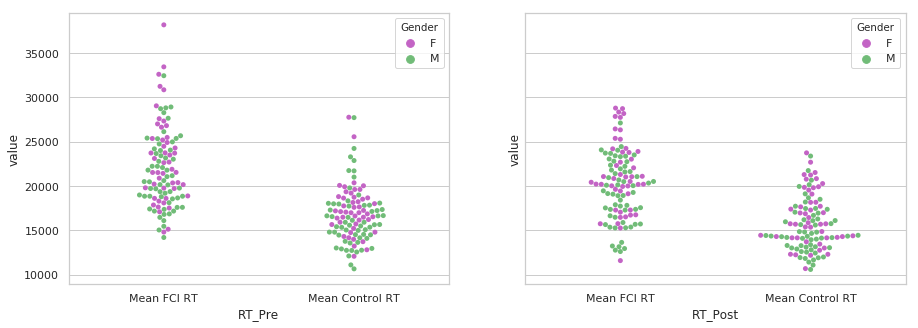

In [20]:
fig, ax = plt.subplots(1, ncols=2, figsize=(15, 5), sharey=True)
g = sns.swarmplot(x="RT_Pre", y="value", hue="Gender", 
                  data=df_rt_pre_gender, palette=crayons, size=5, ax=ax[0])
g = sns.swarmplot(x="RT_Post", y="value", hue="Gender", 
                  data=df_rt_post_gender, palette=crayons, size=5, ax=ax[1])

In [21]:
#want new df with acc + gender, annotated by pre + post
df_acc_pre = df_acc[df_acc['Session'] == 'pre']
df_acc_post = df_acc[df_acc['Session'] == 'post']
df_wide = pd.merge(df_acc_pre,df_acc_post,on=['Subject'],suffixes=('_pre','_post'))
df_wide = df_wide.rename(index=str, columns={"Gender_pre": "Gender", "Class_pre": "Class"})
df_wide = df_wide.drop(['Gender_post', 'Class_post'], axis=1)

df_fci_ac = df_wide.melt(id_vars='Gender', value_vars=['Mean FCI Accuracy_pre', 'Mean FCI Accuracy_post'],
                 var_name='FCI Accuracy')
df_fci_ac.replace(to_replace='Mean FCI Accuracy_pre', value='Pre', inplace=True)
df_fci_ac.replace(to_replace='Mean FCI Accuracy_post', value='Post', inplace=True)

df_control_ac = df_wide.melt(id_vars='Gender', value_vars=['Mean Control Accuracy_pre', 'Mean Control Accuracy_post'],
                 var_name='Control Accuracy')
df_control_ac.replace(to_replace='Mean Control Accuracy_pre', value='Pre', inplace=True)
df_control_ac.replace(to_replace='Mean Control Accuracy_post', value='Post', inplace=True)

df_fci_rt = df_wide.melt(id_vars='Gender', value_vars=['Mean FCI RT_pre', 'Mean FCI RT_post'],
                 var_name='FCI Response Time')
df_fci_rt.replace(to_replace='Mean FCI RT_pre', value='Pre', inplace=True)
df_fci_rt.replace(to_replace='Mean FCI RT_post', value='Post', inplace=True)

df_control_rt = df_wide.melt(id_vars='Gender', value_vars=['Mean Control RT_pre', 'Mean Control RT_post'],
                 var_name='Control Response Time')
df_control_rt.replace(to_replace='Mean Control RT_pre', value='Pre', inplace=True)
df_control_rt.replace(to_replace='Mean Control RT_post', value='Post', inplace=True)

df_wide.head()

,Subject,Session_pre,Mean FCI Accuracy_pre,Mean Control Accuracy_pre,Mean FCI RT_pre,Mean Control RT_pre,Mean FCI Screen1 RT_pre,Mean FCI Screen2 RT_pre,Mean FCI Screen3 RT_pre,Mean Non-FCI Screen1 RT_pre,...,Mean FCI Accuracy_post,Mean Control Accuracy_post,Mean FCI RT_post,Mean Control RT_post,Mean FCI Screen1 RT_post,Mean FCI Screen2 RT_post,Mean FCI Screen3 RT_post,Mean Non-FCI Screen1 RT_post,Mean Non-FCI Screen2 RT_post,Mean Non-FCI Screen3 RT_post
0,101,pre,0.333333,0.888889,20889.666667,18146.111111,7194.111111,6198.000000,7497.555556,7245.444444,...,0.444444,1.0,15754.111111,15741.888889,5844.777778,4764.888889,5144.444444,6333.777778,3370.111111,6038.000000
1,102,pre,0.222222,0.888889,18121.111111,15907.111111,7461.777778,4093.555556,6565.777778,6357.888889,...,0.555556,1.0,17289.000000,16284.555556,4861.111111,4589.555556,7838.333333,5885.888889,2055.666667,8343.000000
2,103,pre,0.444444,1.000000,20477.666667,14463.555556,5530.777778,5820.000000,9126.888889,5617.777778,...,0.777778,1.0,23510.333333,17462.000000,5650.444444,5421.222222,12438.666667,5695.666667,2634.555556,9131.777778
3,104,pre,0.444444,0.888889,29051.888889,18738.444444,10098.000000,10530.444444,8423.444444,7480.777778,...,0.555556,1.0,20007.000000,16993.666667,8777.555556,6751.000000,4478.444444,8680.333333,2781.444444,5531.888889
4,106,pre,0.333333,1.000000,17367.333333,12109.333333,6488.000000,3731.000000,7148.333333,5305.333333,...,0.333333,1.0,20949.111111,14654.777778,6630.555556,5566.666667,8751.888889,6308.777778,2677.666667,5668.333333


/home/data/nbc/nbclab-env/env-py2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


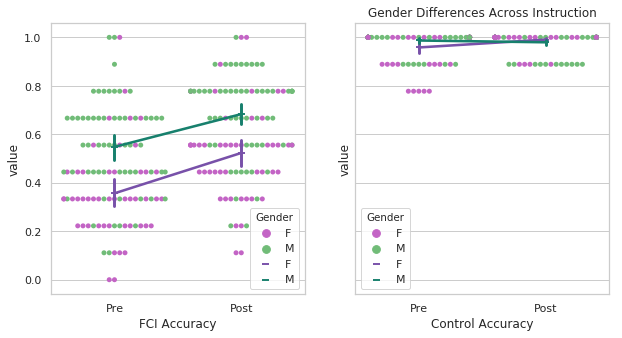

In [22]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharex=False, sharey=True)

linewidth = 0.95

sns.swarmplot(x="FCI Accuracy", y="value", hue="Gender", data=df_fci_ac, 
              palette=crayons, ax=ax[0], zorder=1)
sns.pointplot(x="FCI Accuracy", y="value", hue="Gender", data=df_fci_ac, 
              palette=dark_crayons, ax=ax[0], zorder=100, dodge=False, 
              scale=linewidth, errwidth=linewidth+2,
              markers='_')

sns.swarmplot(x="Control Accuracy", y="value", hue="Gender", data=df_control_ac, 
              palette=crayons, ax=ax[1], zorder=1)
sns.pointplot(x="Control Accuracy", y="value", hue="Gender", data=df_control_ac, 
              palette=dark_crayons, ax=ax[1], zorder=100, dodge=False, 
              scale=linewidth, errwidth=linewidth+2,
              markers='_')

plt.title('Gender Differences Across Instruction')

fig.savefig(path.join(basedir, plotdir, 'mean_fci+control_acc_gender_swarmplot.png'), dpi=400)

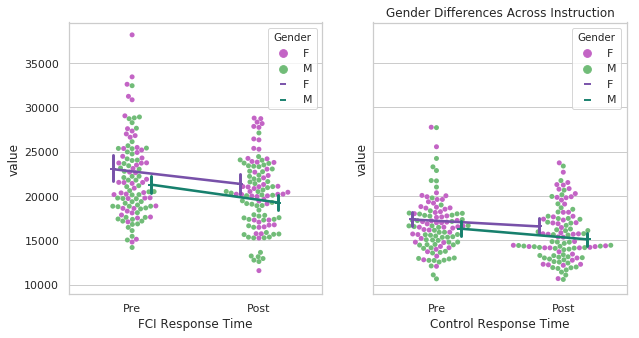

In [23]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharex=False, sharey=True)

linewidth = 0.95

sns.swarmplot(x="FCI Response Time", y="value", hue="Gender", data=df_fci_rt, 
              palette=crayons, ax=ax[0], zorder=1)
sns.pointplot(x="FCI Response Time", y="value", hue="Gender", data=df_fci_rt, 
              palette=dark_crayons, ax=ax[0], zorder=100, dodge=.3, 
              scale=linewidth, errwidth=linewidth+2,
              markers='_')

sns.swarmplot(x="Control Response Time", y="value", hue="Gender", data=df_control_rt, 
              palette=crayons, ax=ax[1], zorder=1)
sns.pointplot(x="Control Response Time", y="value", hue="Gender", data=df_control_rt, 
              palette=dark_crayons, ax=ax[1], zorder=100, dodge=.38, 
              scale=linewidth, errwidth=linewidth+2,
              markers='_')

plt.title('Gender Differences Across Instruction')

fig.savefig(path.join(basedir, plotdir, 'mean_fci+control_rt_gender_swarmplot.png'), dpi=400)

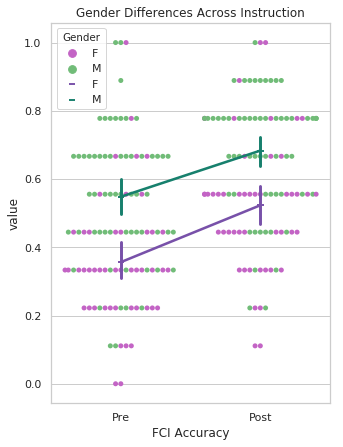

In [24]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 7), sharex=False, sharey=True)

linewidth = 0.95

sns.swarmplot(x="FCI Accuracy", y="value", hue="Gender", size=5,
              data=df_fci_ac, palette=crayons, ax=ax, zorder=1)
sns.pointplot(x="FCI Accuracy", y="value", hue="Gender", 
              data=df_fci_ac, palette=dark_crayons, ax=ax, zorder=100, 
              dodge=False, scale=linewidth, errwidth=linewidth+2,
              markers='_')

plt.title('Gender Differences Across Instruction')

fig.savefig(path.join(basedir, plotdir, 'mean_fci_acc_gender_swarmplot.png'), dpi=400)

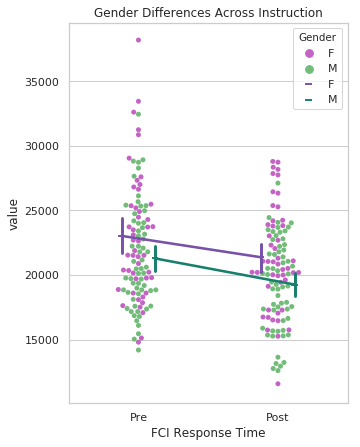

In [25]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 7), sharex=False, sharey=True)

linewidth = 0.95

sns.swarmplot(x="FCI Response Time", y="value", hue="Gender", size=5,
              data=df_fci_rt, palette=crayons, ax=ax, zorder=1)
sns.pointplot(x="FCI Response Time", y="value", hue="Gender", 
              data=df_fci_rt, palette=dark_crayons, ax=ax, zorder=100, 
              dodge=.24, scale=linewidth, errwidth=linewidth+2,
              markers='_')
plt.title('Gender Differences Across Instruction')
            
fig.savefig(path.join(basedir, plotdir, 'mean_fci_rt_gender_swarmplot.png'), dpi=400)

In [26]:
# want new df's for class
df_fci_ac_class = df_wide.melt(id_vars='Class', value_vars=['Mean FCI Accuracy_pre', 'Mean FCI Accuracy_post'],
                 var_name='FCI Accuracy')
df_fci_ac_class.replace(to_replace='Mean FCI Accuracy_pre', value='Pre', inplace=True)
df_fci_ac_class.replace(to_replace='Mean FCI Accuracy_post', value='Post', inplace=True)

df_control_ac_class = df_wide.melt(id_vars='Class', value_vars=['Mean Control Accuracy_pre', 'Mean Control Accuracy_post'],
                 var_name='Control Accuracy')
df_control_ac_class.replace(to_replace='Mean Control Accuracy_pre', value='Pre', inplace=True)
df_control_ac_class.replace(to_replace='Mean Control Accuracy_post', value='Post', inplace=True)

df_fci_rt_class = df_wide.melt(id_vars='Class', value_vars=['Mean FCI RT_pre', 'Mean FCI RT_post'],
                 var_name='FCI Response Time')
df_fci_rt_class.replace(to_replace='Mean FCI RT_pre', value='Pre', inplace=True)
df_fci_rt_class.replace(to_replace='Mean FCI RT_post', value='Post', inplace=True)

df_control_rt_class = df_wide.melt(id_vars='Class', value_vars=['Mean Control RT_pre', 'Mean Control RT_post'],
                 var_name='Control Response Time')
df_control_rt_class.replace(to_replace='Mean Control RT_pre', value='Pre', inplace=True)
df_control_rt_class.replace(to_replace='Mean Control RT_post', value='Post', inplace=True)
df_fci_ac_class.tail()

,Class,FCI Accuracy,value
211,Modeling,Post,0.888889
212,Modeling,Post,0.666667
213,Modeling,Post,0.444444
214,Modeling,Post,0.888889
215,Lecture,Post,1.000000


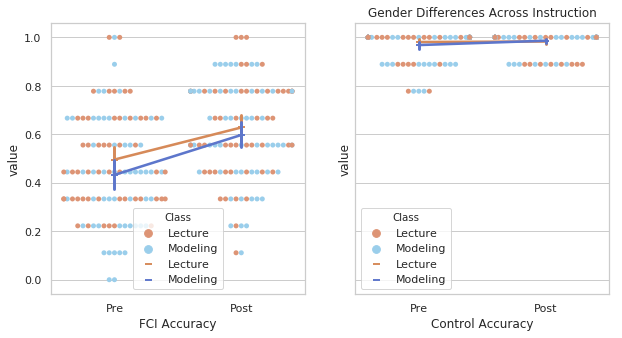

In [27]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharex=False, sharey=True)

sns.swarmplot(x="FCI Accuracy", y="value", hue="Class", data=df_fci_ac_class, 
              palette=class_crayons, ax=ax[0], zorder=1)
sns.pointplot(x="FCI Accuracy", y="value", hue="Class", data=df_fci_ac_class, 
              palette=class_dark_crayons, ax=ax[0], zorder=100, dodge=False, 
              scale=linewidth, errwidth=linewidth+2,
              markers='_')

sns.swarmplot(x="Control Accuracy", y="value", hue="Class", data=df_control_ac_class, 
              palette=class_crayons, ax=ax[1], zorder=1)
sns.pointplot(x="Control Accuracy", y="value", hue="Class", data=df_control_ac_class, 
              palette=class_dark_crayons, ax=ax[1], zorder=100, dodge=False, 
              scale=linewidth, errwidth=linewidth+2,
              markers='_')

plt.title('Gender Differences Across Instruction')

fig.savefig(path.join(basedir, plotdir, 'mean_fci+control_acc_class_swarmplot.png'), dpi=400)

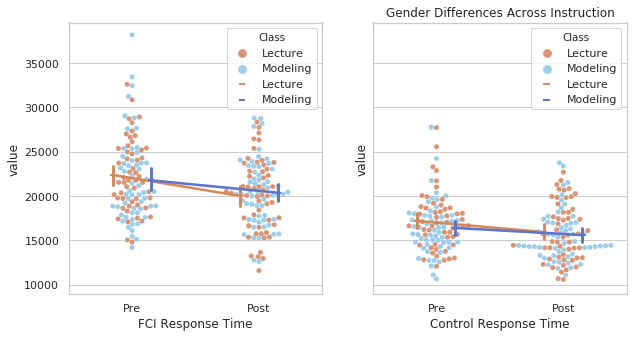

In [28]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharex=False, sharey=True)

sns.swarmplot(x="FCI Response Time", y="value", hue="Class", data=df_fci_rt_class, 
              palette=class_crayons, ax=ax[0], zorder=1)
sns.pointplot(x="FCI Response Time", y="value", hue="Class", data=df_fci_rt_class, 
              palette=class_dark_crayons, ax=ax[0], zorder=100, dodge=.3, 
              scale=linewidth, errwidth=linewidth+2,
              markers='_')

sns.swarmplot(x="Control Response Time", y="value", hue="Class", data=df_control_rt_class, 
              palette=class_crayons, ax=ax[1], zorder=1)
sns.pointplot(x="Control Response Time", y="value", hue="Class", data=df_control_rt_class, 
              palette=class_dark_crayons, ax=ax[1], zorder=100, dodge=.3, 
              scale=linewidth, errwidth=linewidth+2,
              markers='_')

plt.title('Gender Differences Across Instruction')

fig.savefig(path.join(basedir, plotdir, 'mean_fci+control_rt_class_swarmplot.png'), dpi=400)